In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Contents


1. The datasets
2. Patient
3. Tumour <br/>
&nbsp; 3.1  merge av_tumour and av_patient
4. sact_regimen
5. sact_tumour <br/>
&nbsp; 5.1  merge sact_tumour sact_regimen
6. sact_outcome <br/>
&nbsp; 6.1 merge sact_outcome and sact_regimen
7. sact_cycle
8. sact_patient
9. sact_drug_detail

# 1. The datasets

This is a table of all the columns in each dataset, there are a lot so it might be useful to see all of them in one table

**can scroll this table left/right**

In [2]:
datadict = pd.ExcelFile('Simulacrum-data-dictionary.xlsx')
sheets = datadict.sheet_names[1:]
DF = pd.DataFrame()
for sheet in sheets:
    df = pd.read_excel(datadict,sheet)
    df[sheet] = df['Field name']
    DF = pd.concat([DF,df[sheet]], axis=1)

DF

,AV_PATIENT,AV_TUMOUR,SACT PATIENT,SACT TUMOUR,SACT REGIMEN,SACT OUTCOME,SACT CYCLE,SACT DRUG_DETAIL
0,PATIENTID,TUMOURID,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID,MERGED_OUTCOME_ID,MERGED_CYCLE_ID,MERGED_DRUG_DETAIL_ID
1,SEX,PATIENTID,LINK_NUMBER,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID,MERGED_REGIMEN_ID,MERGED_CYCLE_ID
2,LINKNUMBER,DIAGNOSISDATEBEST,NaN,CONSULTANT_SPECIALITY_CODE,HEIGHT_AT_START_OF_REGIMEN,DATE_OF_FINAL_TREATMENT,CYCLE_NUMBER,ORG_CODE_OF_DRUG_PROVIDER
3,ETHNICITY,SITE_ICD10_O2,NaN,PRIMARY_DIAGNOSIS,WEIGHT_AT_START_OF_REGIMEN,REGIMEN_MOD_DOSE_REDUCTION,START_DATE_OF_CYCLE,ACTUAL_DOSE_PER_ADMINISTRATION
4,DEATHCAUSECODE_1A,SITE_ICD10_O2_3CHAR,NaN,MORPHOLOGY_CLEAN,INTENT_OF_TREATMENT,REGIMEN_MOD_TIME_DELAY,OPCS_PROCUREMENT_CODE,OPCS_DELIVERY_CODE
5,DEATHCAUSECODE_1B,MORPH_ICD10_O2,NaN,NaN,DATE_DECISION_TO_TREAT,REGIMEN_MOD_STOPPED_EARLY,PERF_STATUS_START_OF_CYCLE,ADMINISTRATION_ROUTE
6,DEATHCAUSECODE_1C,BEHAVIOUR_ICD10_O2,NaN,NaN,START_DATE_OF_REGIMEN,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID,ADMINISTRATION_DATE
7,DEATHCAUSECODE_2,T_BEST,NaN,NaN,MAPPED_REGIMEN,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,DRUG_GROUP
8,DEATHCAUSECODE_UNDERLYING,N_BEST,NaN,NaN,CLINICAL_TRIAL,MERGED_TUMOUR_ID,NaN,MERGED_PATIENT_ID
9,DEATHLOCATIONCODE,M_BEST,NaN,NaN,CHEMO_RADIATION,NaN,NaN,MERGED_TUMOUR_ID


Diagram of how the datasets are linked:

<img src="tablestructure.jpeg" alt="ts" width="500"/>

# 2. Patient

In [3]:
av_patient = pd.read_csv('simulacrum_release_v1.1.0/sim_av_patient.csv')
display(av_patient.head())

,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
0,10000001,2,810000001,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
1,10000002,2,810000002,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-14
2,10000003,1,810000003,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
3,10000004,1,810000004,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-13
4,10000005,2,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16


unique vital status dates:

In [4]:
av_patient["VITALSTATUSDATE"].apply(lambda s: s[0:4]).value_counts()

2017    982336
2015    116384
2016     92416
2014     84727
2013     46206
1900        31
Name: VITALSTATUSDATE, dtype: int64

frequency of each death cause:

[Text(0,0,'deathcause')]

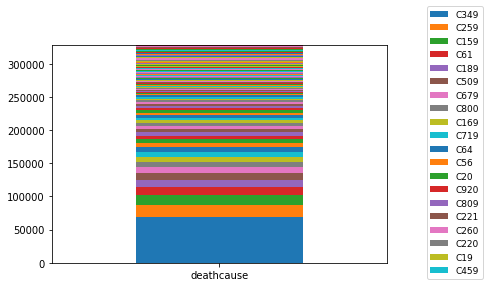

In [5]:
vc = av_patient['DEATHCAUSECODE_UNDERLYING'].value_counts()
ax = pd.DataFrame(vc).T.plot.bar(stacked=True)
handles, labels = ax.get_legend_handles_labels()
top20index = [labels.index(v) for v in vc[:20].keys()]
top20handles = [handles[i] for i in top20index]
ax.legend(top20handles, vc[:20].keys(),loc='best', bbox_to_anchor=(0.8, 0.7, 0.5, 0.5),prop={'size':9})
ax.set_xticklabels(labels=['deathcause'],rotation=0)

non null `"DEATHCAUSECODE_UNDERLYING"` and `"NEWVITALSTATUS" != "D"`:

In [6]:
dead_alive = av_patient[(av_patient["DEATHCAUSECODE_UNDERLYING"].notnull()) \
                        & (av_patient["NEWVITALSTATUS"] != "D")]
len(dead_alive)

179511

# 3. Tumour

In [39]:
av_tumour = pd.read_csv('simulacrum_release_v1.1.0/sim_av_tumour.csv',low_memory=False)
display(av_tumour.head())
print(av_tumour.shape)

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,STAGE_BEST,STAGE_BEST_SYSTEM,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,SCREENINGSTATUSFULL_CODE,ER_STATUS,ER_SCORE,PR_STATUS,PR_SCORE,HER2_STATUS,CANCERCAREPLANINTENT,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015
0,10000001,10000001,2015-11-06,C443,C44,8090,3,NaN,NaN,NaN,?,NaN,GX,90,2,L0801,810000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-06,L,3
1,10000002,10000002,2015-10-06,C449,C44,8090,3,NaN,NaN,NaN,?,NaN,GX,84,2,L0301,810000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-06,8,2
2,10000003,10000003,2013-01-30,C449,C44,8090,3,NaN,NaN,NaN,?,NaN,GX,68,1,L0401,810000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1 - least deprived
3,10000004,10000004,2015-09-15,C449,C44,8090,3,NaN,NaN,NaN,?,NaN,GX,69,1,L1001,810000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,2
4,10000005,10000005,2014-11-01,C449,C44,8090,3,NaN,NaN,NaN,U,NaN,GX,58,2,L0401,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-01,8,2


(1402817, 34)


Unique diagnosis years:

In [40]:
av_tumour["DIAGNOSISDATEBEST"].apply(lambda s: s[0:4]).value_counts()

2015    473666
2014    467145
2013    462006
Name: DIAGNOSISDATEBEST, dtype: int64

Making some bar plots of the tumour features, colour coded with the tumour site:

In [41]:
tumour_features = av_tumour[['SITE_ICD10_O2_3CHAR', 'BEHAVIOUR_ICD10_O2', 'T_BEST',
                            'N_BEST', 'M_BEST', 'STAGE_BEST', 'STAGE_BEST_SYSTEM', 'GRADE', 'AGE',
                            'CANCERCAREPLANINTENT', 'PERFORMANCESTATUS', 'ACE27','LATERALITY']]
vc = av_tumour['SITE_ICD10_O2_3CHAR'].value_counts()
vc[:20] #top20tumoursites

C44    350130
C50    133907
C61    119347
C34    102350
D06     76678
C18     65825
C43     38155
C20     27163
C64     26195
D09     25193
C67     24643
C54     21849
C25     21344
C15     20996
D05     19777
C83     18264
D03     17123
C56     16939
C16     15298
C90     13504
Name: SITE_ICD10_O2_3CHAR, dtype: int64

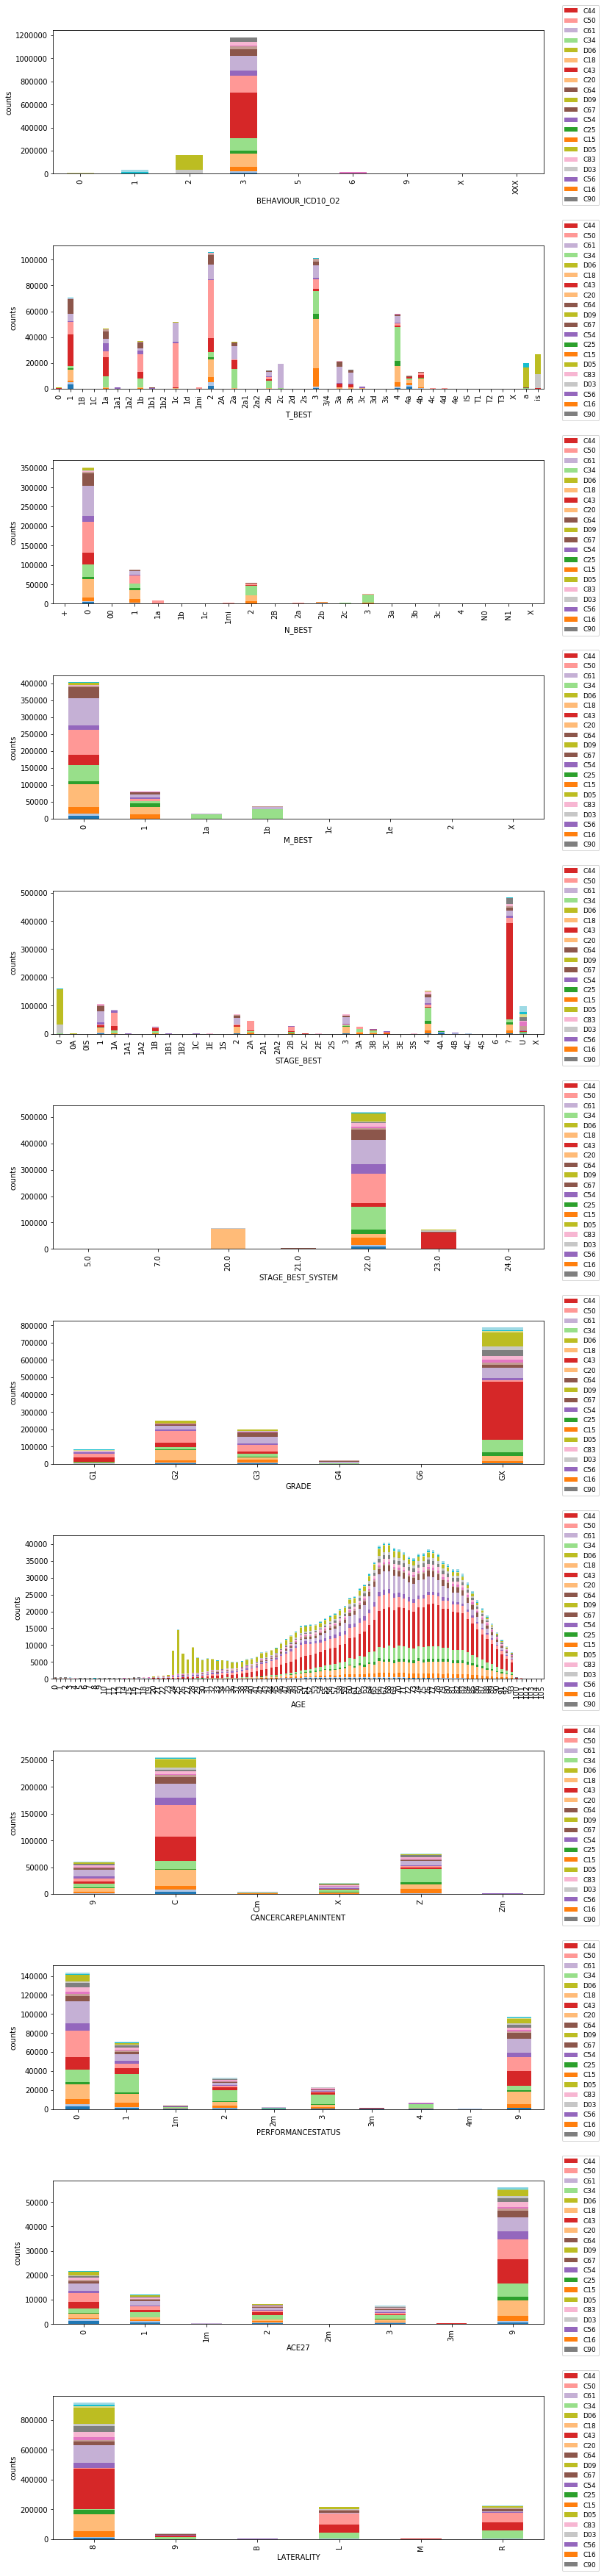

In [44]:
tf_keys = list(tumour_features.keys())
tf_keys.remove('SITE_ICD10_O2_3CHAR')
fig, axes = plt.subplots(nrows=len(tf_keys), ncols=1, figsize=(10,4*len(tf_keys)))
fig.tight_layout()
for i,col in enumerate(tf_keys):
    
    feature = tumour_features[['SITE_ICD10_O2_3CHAR',col]] \
                        .groupby([col, 'SITE_ICD10_O2_3CHAR']) \
                        .agg({'SITE_ICD10_O2_3CHAR':'size'}) \
                        .rename(columns={'SITE_ICD10_O2_3CHAR':'site count'}) \
                        .reset_index()
    feature = feature.pivot(index=col, columns='SITE_ICD10_O2_3CHAR')['site count']
    ax = feature.plot(kind='bar', stacked=True, ax=axes[i], colormap='tab20')
    handles, labels = ax.get_legend_handles_labels()
    top20index = [labels.index(v) for v in vc[:20].keys()]
    top20handles = [handles[i] for i in top20index]
    ax.legend(top20handles, vc[:20].keys(),loc='best', bbox_to_anchor=(0.62, 0.7, 0.5, 0.5),prop={'size':9})
    ax.set_ylabel('counts')
plt.subplots_adjust(hspace=0.5)

The colours in these plots are the site of the tumour, the legend only shows the top 20 sites

incorrect 3 letter ICD10 codes

In [10]:
incorrect = av_tumour['SITE_ICD10_O2'].apply(lambda s: str(s)[0:3]) \
            != av_tumour['SITE_ICD10_O2_3CHAR']
print(incorrect.value_counts())
display(av_tumour[incorrect].tail())


False    1348656
True       54161
dtype: int64


,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015
1402811,220052217,220023092,2014-09-30,C160,C44,8312,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1 - least deprived
1402812,220052218,220023285,2015-09-03,C313,C34,8140,3,1a,0,0,...,NaN,Y1,NaN,NaN,NaN,NaN,NaN,NaN,R,2
1402814,220052225,220045122,2015-01-30,D075,D01,8140,2,NaN,NaN,NaN,...,0,99,NaN,NaN,NaN,NaN,NaN,2015-02-07,8,2
1402815,220052228,220010521,2015-11-02,C051,C61,8000,3,NaN,2,1,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,5 - most deprived
1402816,220052229,220014422,2015-10-27,C441,C64,8046,3,2a,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,5 - most deprived


### 3.1 merge av_tumour and av_patient

In [11]:
tumour_patient = pd.merge(av_tumour,av_patient,on='PATIENTID')
print(av_tumour.shape,av_patient.shape,tumour_patient.shape) 

(1402817, 34) (1322100, 12) (1402817, 45)


create column with days between date of vital status taken and date of diagnosis

In [12]:
from datetime import date

diagnosis_dates = pd.to_datetime(tumour_patient['DIAGNOSISDATEBEST'])
vitalstat_dates = pd.to_datetime(tumour_patient['VITALSTATUSDATE'])

tumour_patient['VITAL - DIAGNOSIS (days)'] = vitalstat_dates - diagnosis_dates
tumour_patient['VITAL - DIAGNOSIS (days)'] = [i.days for i in tumour_patient['VITAL - DIAGNOSIS (days)']]
tumour_patient = tumour_patient[tumour_patient['VITAL - DIAGNOSIS (days)'] >= 0] #some have vital status in 1900

print("stats for days being alive")
tumour_patient['VITAL - DIAGNOSIS (days)'].describe()

stats for days being alive


count    1.402784e+06
mean     7.674820e+02
std      4.079234e+02
min      0.000000e+00
25%      4.660000e+02
50%      7.690000e+02
75%      1.105000e+03
max      1.484000e+03
Name: VITAL - DIAGNOSIS (days), dtype: float64

plots of mean days alive from patients that died

In [13]:
dead_patient = tumour_patient[tumour_patient['NEWVITALSTATUS'] == 'D']

time_behav = dead_patient[dead_patient['BEHAVIOUR_ICD10_O2'] != 'XXX'].dropna(subset=['BEHAVIOUR_ICD10_O2'])
time_behav['BEHAVIOUR_ICD10_O2'] = time_behav['BEHAVIOUR_ICD10_O2'].astype(int)
time_behav['VITAL - DIAGNOSIS (days)'] = time_behav['VITAL - DIAGNOSIS (days)'].astype(float)
mean_days_alive = time_behav[['SITE_ICD10_O2_3CHAR','BEHAVIOUR_ICD10_O2' , 'VITAL - DIAGNOSIS (days)']] \
                    .groupby(['SITE_ICD10_O2_3CHAR','BEHAVIOUR_ICD10_O2']) \
                    .agg({'SITE_ICD10_O2_3CHAR':'size', 'VITAL - DIAGNOSIS (days)':'mean'}) \
                    .rename(columns={'SITE_ICD10_O2_3CHAR':'site count','VITAL - DIAGNOSIS (days)':'mean days alive'}) \
                    .reset_index()

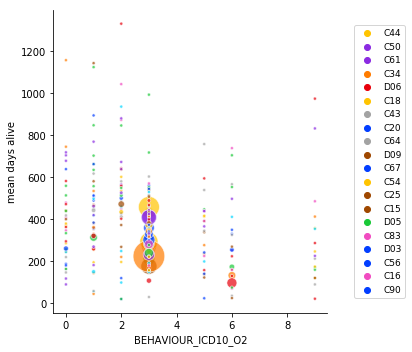

In [14]:
p = sns.relplot(x="BEHAVIOUR_ICD10_O2", y="mean days alive", hue="SITE_ICD10_O2_3CHAR", size="site count",
            sizes=(10, 1000), alpha=.7,
            height=5, data=mean_days_alive, palette='bright')
handles, labels = p.ax.get_legend_handles_labels()
top20index = [labels.index(v) for v in vc[:20].keys()]
top20handles = [handles[i] for i in top20index]
p.ax.legend(top20handles, vc[:20].keys(),loc='right', bbox_to_anchor=(0.8, 0.25, 0.5, 0.5),prop={'size':9})
p._legend.remove()

On the legend is the top 20 tumour

Different colors mean different tumour sites

The sizes of the blobs represent the number of people who have that tumour

There isn't a clear correlation between the time alive and the behaviour of the tumour(how bad the tumour is)

# 4. Sact_regimen

https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python - loading sim_sact_regimen

there are multiple regimens for some tumours

In [15]:
sact_regimen = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_regimen.csv',encoding="ISO-8859-1")
sact_regimen.head()

,MERGED_REGIMEN_ID,MERGED_TUMOUR_ID,HEIGHT_AT_START_OF_REGIMEN,WEIGHT_AT_START_OF_REGIMEN,INTENT_OF_TREATMENT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,MAPPED_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,MERGED_PATIENT_ID,BENCHMARK_GROUP
0,10000001,10000001,-1.0,NaN,N,2015-03-08,2015-03-08,DEGARELIX,NaN,N,10000235,HORMONES
1,10000002,10000002,NaN,NaN,P,2016-07-09,2016-07-10,BICALUTAMIDE + GOSERELIN,NaN,N,10000315,HORMONES
2,10000003,10000003,NaN,NaN,P,2014-01-09,2014-01-09,EXEMESTANE,02,N,10000337,HORMONES
3,10000004,10000004,NaN,NaN,NaN,2015-03-17,2015-03-23,Rituximab,N,NaN,10000480,RITUXIMAB
4,10000005,10000005,0.0,NaN,C,2012-12-30,2013-03-11,Hydroxycarbamide,N,N,10000533,HYDROXYCARBAMIDE


# 5. Sact_tumour

tumours that have received systemic anti-cancer therapy

In [16]:
sact_tumour = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_tumour.csv')
sact_tumour.head()

,MERGED_TUMOUR_ID,MERGED_PATIENT_ID,CONSULTANT_SPECIALITY_CODE,PRIMARY_DIAGNOSIS,MORPHOLOGY_CLEAN
0,10000001,10000235,101.0,C61,81403.0
1,10000002,10000315,101.0,C679,81403.0
2,10000003,10000337,100.0,C500,NaN
3,10000004,10000480,303.0,C829,NaN
4,10000005,10000533,823.0,D473,NaN


### 5.1 merge sact_tumour sact_regimen

In [17]:
tumour_regimen = pd.merge(sact_tumour,sact_regimen,on='MERGED_TUMOUR_ID')
print(sact_tumour.shape, sact_regimen.shape, tumour_regimen.shape) 

(299727, 5) (471919, 12) (471919, 16)


Text(0,0.5,'counts')

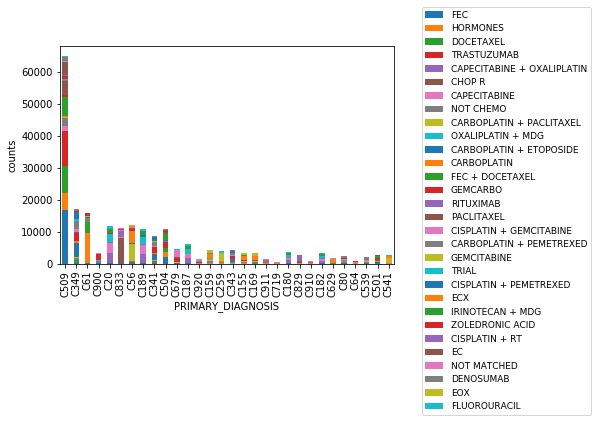

In [18]:
col = 'PRIMARY_DIAGNOSIS'
regimen_feature = tumour_regimen[['BENCHMARK_GROUP',col]] \
                    .groupby([col, 'BENCHMARK_GROUP']) \
                    .agg({'BENCHMARK_GROUP':'size'}) \
                    .rename(columns={'BENCHMARK_GROUP':'Regimen count'}) \
                    .reset_index()
regimen_feature = regimen_feature.pivot(index=col, columns='BENCHMARK_GROUP')['Regimen count']

#top30 diagnosis
vcdiagnosis = tumour_regimen['PRIMARY_DIAGNOSIS'].value_counts()
regimen_feature = regimen_feature.loc[list(vcdiagnosis[:30].keys())]

#top30 regimens
vc = tumour_regimen['BENCHMARK_GROUP'].value_counts()
topreg = regimen_feature[list(vc[:30].keys())]

ax = topreg.plot(kind='bar', stacked=True)
ax.legend(bbox_to_anchor=(1.1, 0.7, 0.5, 0.5),prop={'size':9})
ax.set_ylabel('counts')


This is a frequency plot of primary diagnosis of patients with the different colours as the BENCHMARK_GROUP(type of regimen i think) given to that patient.

this only shows the top 30 PRIMARY_DIAGNOSIS and top 30 BENCHMARK_GROUP

# 6. sact_outcome

In [19]:
sact_outcome = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_outcome.csv')
sact_outcome.head()

,MERGED_OUTCOME_ID,MERGED_REGIMEN_ID,DATE_OF_FINAL_TREATMENT,REGIMEN_MOD_DOSE_REDUCTION,REGIMEN_MOD_TIME_DELAY,REGIMEN_MOD_STOPPED_EARLY,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID,MERGED_TUMOUR_ID
0,10000001,10000003,2014-01-09,N,N,N,NaN,10000337,10000003
1,10000002,10000005,NaN,Y,Y,N,NaN,10000533,10000005
2,10000003,10000006,NaN,N,Y,N,NaN,10000697,10000006
3,10000004,10000007,NaN,Y,NaN,N,NaN,10000697,10000006
4,10000005,10000008,2012-12-07,NaN,NaN,NaN,NaN,10000773,10009036


In [20]:
sact_outcome.shape

(351668, 9)

### 6.1 merge sact_outcome and sact_regimen

In [21]:
outcome_regimen = pd.merge(sact_regimen,sact_outcome,on='MERGED_REGIMEN_ID')
print(sact_outcome.shape, sact_regimen.shape, outcome_regimen.shape) 

(351668, 9) (471919, 12) (351668, 20)


Text(0,0.5,'counts')

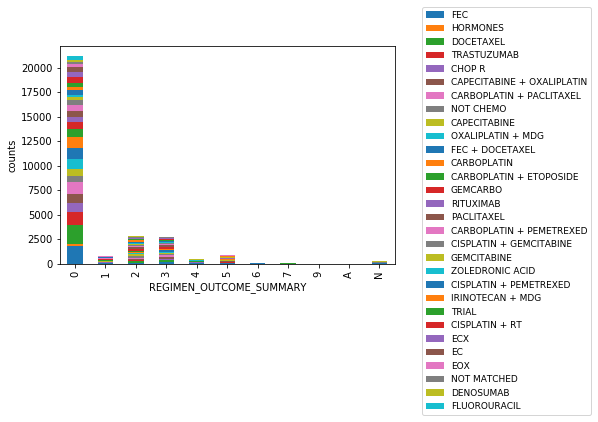

In [22]:
col = 'REGIMEN_OUTCOME_SUMMARY'
regimen_feature = outcome_regimen[['BENCHMARK_GROUP',col]] \
                    .groupby([col, 'BENCHMARK_GROUP']) \
                    .agg({'BENCHMARK_GROUP':'size'}) \
                    .rename(columns={'BENCHMARK_GROUP':'Regimen count'}) \
                    .reset_index()
regimen_feature = regimen_feature.pivot(index=col, columns='BENCHMARK_GROUP')['Regimen count']

vc = outcome_regimen['BENCHMARK_GROUP'].value_counts()
topreg = regimen_feature[list(vc[:30].keys())]
ax = topreg.plot(kind='bar', stacked=True)
ax.legend(bbox_to_anchor=(1.1, 0.7, 0.5, 0.5),prop={'size':9})
ax.set_ylabel('counts')

This is a frequency plot of REGIMEN_OUTCOME_SUMMARY with the different colours as the BENCHMARK_GROUP.

# 7. sact_cycle

In [23]:
sact_cycle = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_cycle.csv', low_memory=False)
display(sact_cycle.head())

print('shape ',sact_cycle.shape)

for col in list(sact_cycle.columns):
    print(col," ",sact_cycle[col].unique()[0:6])

,MERGED_CYCLE_ID,MERGED_REGIMEN_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,OPCS_PROCUREMENT_CODE,PERF_STATUS_START_OF_CYCLE,MERGED_PATIENT_ID,MERGED_TUMOUR_ID
0,10000001,10000001,4,2015-06-07,NaN,NaN,10000235,10000001
1,10000002,10000002,2,2016-08-07,NaN,00,10000315,10000002
2,10000003,10000003,3,NaN,X715,NaN,10000337,10000003
3,10000004,10000004,2,2015-03-23,X712,0,10000480,10000004
4,10000005,10000005,1,2013-03-11,X711,NaN,10000533,10000005


shape  (1462099, 8)
MERGED_CYCLE_ID   [10000001 10000002 10000003 10000004 10000005 10000006]
MERGED_REGIMEN_ID   [10000001 10000002 10000003 10000004 10000005 10000006]
CYCLE_NUMBER   [ 4  2  3  1  5 11]
START_DATE_OF_CYCLE   ['2015-06-07' '2016-08-07' nan '2015-03-23' '2013-03-11' '2012-06-29']
OPCS_PROCUREMENT_CODE   [nan 'X715' 'X712' 'X711' 'X713' 'X702']
PERF_STATUS_START_OF_CYCLE   [nan '00' '0' '1' '-1' '2']
MERGED_PATIENT_ID   [10000235 10000315 10000337 10000480 10000533 10000697]
MERGED_TUMOUR_ID   [10000001 10000002 10000003 10000004 10000005 10000006]


# 8. sact_patient

In [24]:
sact_patient = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_patient.csv')
display(sact_patient.head())

print('shape ',sact_patient.shape)

for col in list(sact_patient.columns):
    print(col," ",sact_patient[col].unique()[0:6])

,MERGED_PATIENT_ID,LINK_NUMBER
0,10000087,810000087
1,10000235,810000235
2,10000283,810000283
3,10000315,810000315
4,10000337,810000337


shape  (245938, 2)
MERGED_PATIENT_ID   [10000087 10000235 10000283 10000315 10000337 10000365]
LINK_NUMBER   [810000087 810000235 810000283 810000315 810000337 810000365]


# 9. sact_drug_detail

In [25]:
drug_detail = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_drug_detail.csv')
display(drug_detail.head())

print('shape ',drug_detail.shape)

for col in list(drug_detail.columns):
    print(col," ",drug_detail[col].unique()[0:6])

,MERGED_DRUG_DETAIL_ID,MERGED_CYCLE_ID,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID
0,10000001,10000001,EKD02,10.0,NaN,1.0,2015-06-07,STEROID,10000235,10000001,10000001
1,10000002,10000002,EGU02,30.0,NaN,2.0,NaN,NOT CHEMO,10000315,10000002,10000002
2,10000003,10000003,EGU05,1000.0,NaN,1.0,NaN,RITUXIMAB,10000337,10000003,10000003
3,10000004,10000004,EXO,8.0,X723,2.0,2015-03-23,NOT CHEMO,10000480,10000004,10000004
4,10000005,10000005,ETD02,1000.0,NaN,2.0,2013-03-11,NOT CHEMO,10000533,10000005,10000005


shape  (3544584, 11)
MERGED_DRUG_DETAIL_ID   [10000001 10000002 10000003 10000004 10000005 10000006]
MERGED_CYCLE_ID   [10000001 10000002 10000003 10000004 10000005 10000007]
ORG_CODE_OF_DRUG_PROVIDER   ['EKD02' 'EGU02' 'EGU05' 'EXO' 'ETD02' 'ETA42']
ACTUAL_DOSE_PER_ADMINISTRATION   [  10.   30. 1000.    8.  300.  100.]
OPCS_DELIVERY_CODE   [nan 'X723' 'X731' 'x723' 'X729' 'x721']
ADMINISTRATION_ROUTE   [ 1.  2.  5. nan 99.  4.]
ADMINISTRATION_DATE   ['2015-06-07' nan '2015-03-23' '2013-03-11' '2014-07-25' '2012-12-07']
DRUG_GROUP   ['STEROID' 'NOT CHEMO' 'RITUXIMAB' 'DOCETAXEL' 'PACLITAXEL' 'CARBOPLATIN']
MERGED_PATIENT_ID   [10000235 10000315 10000337 10000480 10000533 10000697]
MERGED_TUMOUR_ID   [10000001 10000002 10000003 10000004 10000005 10000006]
MERGED_REGIMEN_ID   [10000001 10000002 10000003 10000004 10000005 10000007]


# 10. Patient pathway/single view of patient

## 10.1 merging all the datasets

All the datasets are merged starting from `av_patient`. `av_tumour` has been excluded for now.

All merges are an inner join.

Only patients that has undertaken a regimen are kept in the end because patients without a regimen are not joined in an inner join.

The order of merging shouldn't matter as long as the datasets are merged according to the table structure in 1.

Rows will be repeated if the number of rows grows on a merge.

In [26]:
# Merge av_patient,sact_patient 
sact_patient = sact_patient.rename(index=str,columns={'LINK_NUMBER':'LINKNUMBER'})
patient_link = pd.merge(av_patient,
                        sact_patient,on='LINKNUMBER')

# Merge sact_tumour
patient_tumour = pd.merge(patient_link, 
                          sact_tumour,on='MERGED_PATIENT_ID')

# Merge sact_regimen
patient_tumour_regimen = pd.merge(patient_tumour, 
                                  sact_regimen,on='MERGED_TUMOUR_ID')

#Merge sact_outcome
patient_tumour_regimen_outcome = pd.merge(patient_tumour_regimen, 
                                          sact_outcome,on='MERGED_REGIMEN_ID')

#Merge sact_cycle
patient_tumour_regimen_outcome_cycle = pd.merge(patient_tumour_regimen_outcome, 
                                                sact_cycle,on='MERGED_REGIMEN_ID')

#Merge drug_detail
patient_tumour_regimen_outcome_cycle_drug = pd.merge(patient_tumour_regimen_outcome_cycle
                                                     ,drug_detail,on='MERGED_CYCLE_ID')

pd.set_option('display.max_columns', 100)

#example patient
p = patient_tumour_regimen_outcome_cycle_drug['PATIENTID'] == 10000283
display(patient_tumour_regimen_outcome_cycle_drug[p])



,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE,MERGED_PATIENT_ID_x,MERGED_TUMOUR_ID_x,CONSULTANT_SPECIALITY_CODE,PRIMARY_DIAGNOSIS,MORPHOLOGY_CLEAN,MERGED_REGIMEN_ID_x,HEIGHT_AT_START_OF_REGIMEN,WEIGHT_AT_START_OF_REGIMEN,INTENT_OF_TREATMENT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,MAPPED_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,MERGED_PATIENT_ID_y,BENCHMARK_GROUP,MERGED_OUTCOME_ID,DATE_OF_FINAL_TREATMENT,REGIMEN_MOD_DOSE_REDUCTION,REGIMEN_MOD_TIME_DELAY,REGIMEN_MOD_STOPPED_EARLY,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID_x,MERGED_TUMOUR_ID_y,MERGED_CYCLE_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,OPCS_PROCUREMENT_CODE,PERF_STATUS_START_OF_CYCLE,MERGED_PATIENT_ID_y,MERGED_TUMOUR_ID_x,MERGED_DRUG_DETAIL_ID,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP,MERGED_PATIENT_ID,MERGED_TUMOUR_ID_y,MERGED_REGIMEN_ID_y
0,10000283,1,810000283,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,10000283,10011465,101.0,C61,NaN,10007970,1.66,83.1,C,2016-02-02,2016-02-02,Docetaxel 75mg/m2 (21 day),02,Y,10000283,DOCETAXEL,10007108,NaN,N,N,N,NaN,10000283,10011465,10007967,1,2016-02-02,X702,1,10000283,10011465,10006484,EZ1,60.0,NaN,2.0,2016-02-02,CHLORAMBUCIL,10000283,10011465,10007970
1,10000283,1,810000283,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,10000283,10011465,101.0,C61,NaN,10007970,1.66,83.1,C,2016-02-02,2016-02-02,Docetaxel 75mg/m2 (21 day),02,Y,10000283,DOCETAXEL,10007108,NaN,N,N,N,NaN,10000283,10011465,10007967,1,2016-02-02,X702,1,10000283,10011465,10038413,EJQ,20.0,NaN,99.0,2016-02-02,CARBOPLATIN,10000283,10011465,10007970
2,10000283,1,810000283,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,10000283,10011465,101.0,C61,NaN,10007971,0.00,-1.0,A,2014-06-29,2014-07-01,ZOLEDRONIC ACID,N,N,10000283,ZOLEDRONIC ACID,10007109,NaN,N,NaN,N,NaN,10000283,10011465,10007968,1,2014-07-22,NaN,0,10000283,10011465,10006485,ETG,10.0,NaN,2.0,2014-07-22,CHLORAMBUCIL,10000283,10011465,10007971
3,10000283,1,810000283,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,10000283,10011465,101.0,C61,NaN,10007972,1.72,NaN,NaN,NaN,2014-10-30,Chlorambucil,N,N,10000283,FLUOROURACIL + MITOMYCIN + RT,10007110,NaN,N,NaN,N,NaN,10000283,10011465,10007969,1,2014-10-30,X715,1,10000283,10011465,10006486,EON,20.0,NaN,2.0,2014-10-30,NOT CHEMO,10000283,10011465,10007972
4,10000283,1,810000283,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,10000283,10011465,101.0,C61,NaN,10007972,1.72,NaN,NaN,NaN,2014-10-30,Chlorambucil,N,N,10000283,FLUOROURACIL + MITOMYCIN + RT,10007110,NaN,N,NaN,N,NaN,10000283,10011465,10016625,2,2014-11-27,NaN,1,10000283,10011465,10013931,ED8Y0,1000.0,X741,2.0,2014-11-27,ABIRATERONE,10000283,10011465,10007972
5,10000283,1,810000283,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,10000283,10011465,101.0,C61,NaN,10007972,1.72,NaN,NaN,NaN,2014-10-30,Chlorambucil,N,N,10000283,FLUOROURACIL + MITOMYCIN + RT,10007110,NaN,N,NaN,N,NaN,10000283,10011465,10022236,4,2014-12-04,X715,NaN,10000283,10011465,10018828,EGENG,600.0,X723,1.0,2014-12-04,RITUXIMAB,10000283,10011465,10007972
6,10000283,1,810000283,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,10000283,10011465,101.0,C61,NaN,10007972,1.72,NaN,NaN,NaN,2014-10-30,Chlorambucil,N,N,10000283,FLUOROURACIL + MITOMYCIN + RT,10007110,NaN,N,NaN,N,NaN,10000283,10011465,10026280,4,2014-12-18,NaN,NaN,10000283,10011465,10022327,E1UZ0,430.0,X731,2.0,2014-12-18,CYCLOPHOSPHAMIDE,10000283,10011465,10007972
7,10000283,1,810000283,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,10000283,10011465,101.0,C61,NaN,10007972,1.72,NaN,NaN,NaN,2014-10-30,Chlorambucil,N,N,10000283,FLUOROURACIL + MITOMYCIN + RT,10007110,NaN,N,NaN,N,NaN,10000283,10011465,10026280,4,2014-12-18,NaN,NaN,10000283,10011465,10059364,EAD51,1000.0,X723,99.0,2014-12-18,RITUXIMAB,10000283,10011465,10007972
8,10000283,1,810000283,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,10000283,10011465,101.0,C61,NaN,10007972,1.72,NaN,NaN,NaN,2014-10-30,

explanation of the changes in the number of rows when merging each dataset:

In [27]:
merges = [av_patient, 
          patient_link, # includes only patients that have undergone a regimen => decrease in rows.
          patient_tumour, # some tumours might have to be "rediagnosed" before starting a new regimen 
                               # => increase in rows.
                               # from looking at sact_tumour/sact_regimen, multiple MERGED_TUMOUR_ID's on 
                               # a single patient does not necessarily correspond to different tumours on that 
                               # patient. Instead, a Regimen(s) will correspond to each MERGED_TUMOUR_ID, 
                               # I think this is because they have to rediagnose the tumour before the start of
                               # a regimen(s).
          patient_tumour_regimen, # some patients have multiple regimens on a tumour => increase in rows.
          patient_tumour_regimen_outcome, # some patients have no recorded outcome? => decrease in rows.
          patient_tumour_regimen_outcome_cycle, # some regimens have multiple cycles => increase in rows
          patient_tumour_regimen_outcome_cycle_drug] # some cycles have multiple drug details => increase in rows.

for df in merges:
    print(df.shape)

(1322100, 12)
(245938, 13)
(299722, 17)
(471912, 28)
(351661, 36)
(1097360, 43)
(2666148, 53)


## 10.2 Patient pathways

As all the data are combined, we can now order all the dates for each patient to create a patient pathway.

For a given `'PATIENTID'` sort the dates by `'START_DATE_OF_REGIMEN'` then sort by `'START_DATE_OF_CYCLE'` then sort by `'ADMINISTRATION_DATE'`:

In [36]:
%%time
patient_pathways = patient_tumour_regimen_outcome_cycle_drug \
                    .groupby('PATIENTID') \
                    .apply(lambda x: x.sort_values(by = 
                                    ['START_DATE_OF_REGIMEN','START_DATE_OF_CYCLE','ADMINISTRATION_DATE'])) 

CPU times: user 9min 57s, sys: 11.9 s, total: 10min 9s
Wall time: 10min 9s


In [37]:
patient_pathways

PATIENTID  SEX  LINKNUMBER ETHNICITY DEATHCAUSECODE_1A  \
PATIENTID                                                                   
10000283  2         10000283    1   810000283         A               NaN   
          3         10000283    1   810000283         A               NaN   
          4         10000283    1   810000283         A               NaN   
          5         10000283    1   810000283         A               NaN   
          6         10000283    1   810000283         A               NaN   
          7         10000283    1   810000283         A               NaN   
          8         10000283    1   810000283         A               NaN   
          0         10000283    1   810000283         A               NaN   
          1         10000283    1   810000283         A               NaN   
10000337  9         10000337    1   810000337         A               NaN   
          10        10000337    1   810000337         A               NaN   
          11        10000337    1   810000337         A               NaN   
10000365  12        10000365    2   810000365         A               NaN   
          13        10000365    2   810000365         A               NaN   
          14        10000365    2   810000365         A               NaN   
          15        10000365    2   810000365         A               NaN   
          16        10000365    2   810000365         A               NaN   
          17        10000365    2   810000365         A               NaN   
10000533  18        10000533    2   810000533         A               NaN   
          19        10000533    2   810000533         A               NaN   
10000697  20        10000697    2   810000697         S               NaN   
          21        10000697    2   810000697         S               NaN   
          22        10000697    2   810000697         S               NaN   
          23        10000697    2   810000697         S               NaN   
          24        10000697    2   810000697         S               NaN   
          25        10000697    2   810000697         S               NaN   
          26        10000697    2   810000697         S               NaN   
          27        10000697    2   810000697         S               NaN   
          28        10000697    2   810000697         S               NaN   
          29        10000697    2   810000697         S               NaN   
...                      ...  ...         ...       ...               ...   
220048551 2666123  220048551    1  1020048551         A         C629,C780   
          2666124  220048551    1  1020048551         A         C629,C780   
          2666125  220048551    1  1020048551         A         C629,C780   
          2666126  220048551    1  1020048551         A         C629,C780   
          2666127  220048551    1  1020048551         A         C629,C780   
          2666117  220048551    1  1020048551         A         C629,C780   
          2666118  220048551    1  1020048551         A         C629,C780   
          2666119  220048551    1  1020048551         A         C629,C780   
          2666120  220048551    1  1020048551         A         C629,C780   
          2666121  220048551    1  1020048551         A         C629,C780   
220048561 2666128  220048561    1  1020048561         S              A419   
          2666129  220048561    1  1020048561         S              A419   
          2666130  220048561    1  1020048561         S              A419   
          2666131  220048561    1  1020048561         S              A419   
220048569 2666132  220048569    1  1020048569         A               NaN   
          2666133  220048569    1  1020048569         A               NaN   
          2666134  220048569    1  1020048569         A               NaN   
          2666135  220048569    1  1020048569         A               NaN   
          2666136  220048569    1  1020048569         A               NaN   
          26661

groupby and sort : https://github.com/pandas-dev/pandas/issues/15947

sort dataframe by date: https://stackoverflow.com/questions/28161356/sort-pandas-dataframe-by-date


In [45]:
#now to choose what columns to keep to get a single view of patient